# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

┌ Info: Precompiling VCFTools [a620830f-fdd7-5ebc-8d26-3621ab35fbfe]
└ @ Base loading.jl:1278
┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [2]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

In [2]:
# map population to super-population
pop_to_superpop = Dict{String, String}()

# 5 east asian
pop_to_superpop["CHB"] = "EAS"; pop_to_superpop["JPT"] = "EAS"; pop_to_superpop["CHS"] = "EAS"; 
pop_to_superpop["CDX"] = "EAS"; pop_to_superpop["KHV"] = "EAS"; 

# 5 european
pop_to_superpop["CEU"] = "EUR"; pop_to_superpop["TSI"] = "EUR"; pop_to_superpop["FIN"] = "EUR";
pop_to_superpop["GBR"] = "EUR"; pop_to_superpop["IBS"] = "EAS";

# 7 african
pop_to_superpop["YRI"] = "AFR"; pop_to_superpop["LWK"] = "AFR"; pop_to_superpop["GWD"] = "AFR"; 
pop_to_superpop["MSL"] = "AFR"; pop_to_superpop["ESN"] = "AFR"; pop_to_superpop["ASW"] = "AFR"; 
pop_to_superpop["ACB"] = "AFR"; 

# 4 ad mixed americans
pop_to_superpop["MXL"] = "AMR"; pop_to_superpop["PUR"] = "AMR"; pop_to_superpop["CLM"] = "AMR"; 
pop_to_superpop["PEL"] = "AMR";

# 5 south asian
pop_to_superpop["GIH"] = "SAS"; pop_to_superpop["PJL"] = "SAS"; pop_to_superpop["BEB"] = "SAS"; 
pop_to_superpop["STU"] = "SAS"; pop_to_superpop["ITU"] = "SAS";

# Get each sample's population and super-population origin

In [3]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
refID_to_population = Dict{String, String}()
refID_to_superpopulation = Dict{String, String}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        refID_to_population[sample] = population
        refID_to_superpopulation[sample] = pop_to_superpop[population]
    end
end
refID_to_superpopulation

Dict{String,String} with 2709 entries:
  "HG01791" => "EUR"
  "HG02736" => "SAS"
  "HG00182" => "EUR"
  "HG03914" => "SAS"
  "HG00149" => "EUR"
  "NA12156" => "EUR"
  "HG02642" => "AFR"
  "HG02851" => "AFR"
  "NA19835" => "AFR"
  "NA19019" => "AFR"
  "HG01131" => "AMR"
  "HG03725" => "SAS"
  "HG03578" => "AFR"
  "NA18550" => "EAS"
  "HG02401" => "EAS"
  "HG01350" => "AMR"
  "HG03973" => "SAS"
  "NA07000" => "EUR"
  "HG01709" => "EAS"
  "HG01395" => "AMR"
  "HG02388" => "EAS"
  "HG01980" => "AMR"
  "HG01979" => "AMR"
  "HG01122" => "AMR"
  "HG03869" => "SAS"
  ⋮         => ⋮

# Compute phase information

Here the target and reference files are generated with the `aim_select.ipynb` notebook under `aim_markers`. 

In [ ]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/aim_markers")
Random.seed!(2020)
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reffile = "ref.chr18.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile);

Number of threads = 8
Importing reference haplotype data...


# Compute sample composition in 1000 genomes

In [5]:
# need compressed reference panel
reffile = "ref.chr18.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];
sample_superpopulation = [refID_to_superpopulation[id] for id in tgtID];

In [6]:
findall(x -> x == "CHS", sample_population)

8-element Array{Int64,1}:
  4
  5
  6
  7
  8
  9
 10
 11

  0.000146 seconds (5 allocations: 688 bytes)
  0.000227 seconds (5 allocations: 688 bytes)
  0.000248 seconds (5 allocations: 688 bytes)


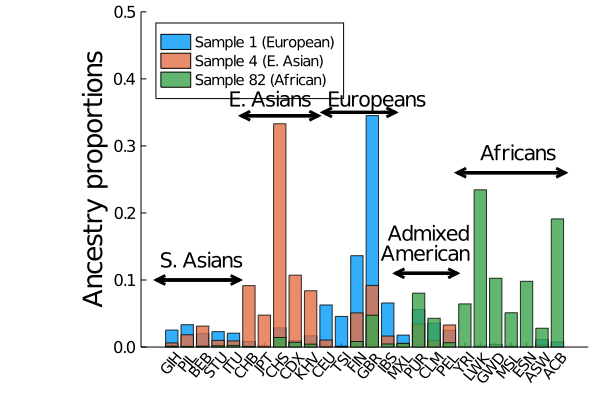

In [50]:
populations = [
    "GIH", "PJL", "BEB", "STU", "ITU",                # 5 south asian
    "CHB", "JPT", "CHS", "CDX", "KHV",                # 5 east asian
    "CEU", "TSI", "FIN", "GBR", "IBS",                # 5 european
    "MXL", "PUR", "CLM", "PEL",                       # 4 ad mixed americans
    "YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB"]  # 7 african

@time sample1_comp = composition(ph[1], panelID, refID_to_population, populations=populations)
@time sample4_comp = composition(ph[4], panelID, refID_to_population, populations=populations)
@time sample82_comp = composition(ph[82], panelID, refID_to_population, populations=populations)

barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=50, grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (European)", alpha=0.8, legend=:topleft,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(10), yguidefontsize=18,
    ylim = (0, 0.5), left_margin = 20Plots.mm)
bar!(barplot, sample4_comp, label="Sample 4 (E. Asian)", alpha=0.8)
bar!(barplot, sample82_comp, label="Sample 82 (African)", alpha=0.8)

plot!(barplot, [0, 5.4], [0.1, 0.1], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [5.4, 0], [0.1, 0.1], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 0.3,  0.13 , text("S. Asians", :left))
plot!(barplot, [5.5, 10.5], [0.345, 0.345], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [10.5, 5.5], [0.345, 0.345], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 4.8,  0.37 , text("E. Asians", :left))
plot!(barplot, [10.8, 15.5], [0.35, 0.35], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [15.5, 10.8], [0.35, 0.35], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 11.2,  0.37 , text("Europeans", :left))
plot!(barplot, [15.5, 19.5], [0.11, 0.11], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [19.5, 15.5], [0.11, 0.11], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 14.55, 0.14 , text("American", :left))
annotate!(barplot, 15.0, 0.17 , text("Admixed", :left))
plot!(barplot, [19.5, 26.5], [0.26, 0.26], linewidth=3.0, color=:black, label=false, arrow=true)
plot!(barplot, [26.5, 19.5], [0.26, 0.26], linewidth=3.0, color=:black, label=false, arrow=true)
annotate!(barplot, 21.0, 0.29 , text("Africans", :left))

  0.000112 seconds (5 allocations: 368 bytes)
  0.000117 seconds (5 allocations: 368 bytes)
  0.000177 seconds (5 allocations: 368 bytes)


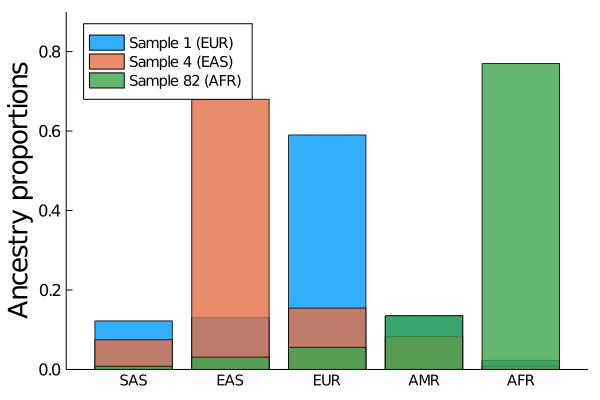

In [31]:
continent = ["SAS", "EAS", "EUR", "AMR", "AFR"]
@time sample1_comp = composition(ph[1], panelID, refID_to_superpopulation, populations=continent)
@time sample4_comp = composition(ph[4], panelID, refID_to_superpopulation, populations=continent)
@time sample82_comp = composition(ph[82], panelID, refID_to_superpopulation, populations=continent)

barplot2 = bar(sample1_comp, xticks=(1:1:5, continent), grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (EUR)", alpha=0.8, legend=:topleft,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(10), yguidefontsize=18, 
    ylim=(0, 0.9))
bar!(barplot2, sample4_comp, label="Sample 4 (EAS)", alpha=0.8)
bar!(barplot2, sample82_comp, label="Sample 82 (AFR)", alpha=0.8)

# Try painting an actual chromosome

Generated colors here: https://mdigi.tools/color-shades/#008000 and https://sashamaps.net/docs/resources/20-colors/.

Colors are arranged such that:
+ Blue ≈ European/American
+ Red ≈ Asian
+ Green ≈ African

In [9]:
@time sample1_s1_pop, sample1_s2_pop = paint(ph[1], panelID, refID_to_population, populations=populations)
@time sample4_s1_pop, sample4_s2_pop = paint(ph[4], panelID, refID_to_population, populations=populations)
@time sample82_s1_pop, sample82_s2_pop = paint(ph[82], panelID, refID_to_population, populations=populations);

  0.072963 seconds (117.66 k allocations: 5.941 MiB)
  0.000086 seconds (12 allocations: 11.531 KiB)
  0.000114 seconds (12 allocations: 15.281 KiB)


In [10]:
@time sample1_s1_cont, sample1_s2_cont = paint(ph[1], panelID, refID_to_superpopulation, populations=continent)
@time sample4_s1_cont, sample4_s2_cont = paint(ph[4], panelID, refID_to_superpopulation, populations=continent)
@time sample82_s1_cont, sample82_s2_cont = paint(ph[82], panelID, refID_to_superpopulation, populations=continent);

  0.000107 seconds (12 allocations: 9.781 KiB)
  0.000098 seconds (12 allocations: 11.531 KiB)
  0.000149 seconds (12 allocations: 15.281 KiB)


In [11]:
# generated here: https://mdigi.tools/color-shades/#008000
# Red ≈ Asian, Blue ≈ European/American, Green ≈ Africa

goodcolors = [colorant"#ffeaea", colorant"#ffbfbf", colorant"#ff9595", colorant"#ff6a6a", 
    colorant"#ff4040", colorant"#ff1515", colorant"#ea0000", colorant"#bf0000", 
    colorant"#950000", colorant"#6a0000", colorant"#c8c8ff", colorant"#a4a4ff", 
    colorant"#8080ff", colorant"#5b5bff", colorant"#3737ff", colorant"#1212ff",
    colorant"#0000c8", colorant"#0000a4", colorant"#00005b", colorant"#e3ffe3", 
    colorant"#aaffaa", colorant"#71ff71", colorant"#39ff39", colorant"#00ff00", 
    colorant"#00c600", colorant"#008e00"]

In [12]:
# super population colors generated here: https://sashamaps.net/docs/resources/20-colors/
# Blue ≈ European, Red = south Asian, Green = African, light blue = american, maroon=east asian
continent = ["SAS", "EAS", "EUR", "AMR", "AFR"]
continent_colors = [colorant"#e6194B", colorant"#800000", colorant"#4363d8", 
    colorant"#42d4f4", colorant"#bfef45",]

In [13]:
# population colors
sample1_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s1_pop[2]]
sample1_s1_colors = reshape(sample1_s1_colors, 1, length(sample1_s1_colors))

sample1_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s2_pop[2]]
sample1_s2_colors = reshape(sample1_s2_colors, 1, length(sample1_s2_colors))

sample4_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s1_pop[2]]
sample4_s1_colors = reshape(sample4_s1_colors, 1, length(sample4_s1_colors))

sample4_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s2_pop[2]]
sample4_s2_colors = reshape(sample4_s2_colors, 1, length(sample4_s2_colors))

sample82_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample82_s1_pop[2]]
sample82_s1_colors = reshape(sample82_s1_colors, 1, length(sample82_s1_colors))

sample82_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample82_s2_pop[2]]
sample82_s2_colors = reshape(sample82_s2_colors, 1, length(sample82_s2_colors));

In [14]:
# super-population colors
sample1_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample1_s1_cont[2]]
sample1_s1_cont_colors = reshape(sample1_s1_cont_colors, 1, length(sample1_s1_cont_colors))

sample1_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample1_s2_cont[2]]
sample1_s2_cont_colors = reshape(sample1_s2_cont_colors, 1, length(sample1_s2_cont_colors))

sample4_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample4_s1_cont[2]]
sample4_s1_cont_colors = reshape(sample4_s1_cont_colors, 1, length(sample4_s1_cont_colors))

sample4_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample4_s2_cont[2]]
sample4_s2_cont_colors = reshape(sample4_s2_cont_colors, 1, length(sample4_s2_cont_colors))

sample82_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample82_s1_cont[2]]
sample82_s1_cont_colors = reshape(sample82_s1_cont_colors, 1, length(sample82_s1_cont_colors))

sample82_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample82_s2_cont[2]]
sample82_s2_cont_colors = reshape(sample82_s2_cont_colors, 1, length(sample82_s2_cont_colors));

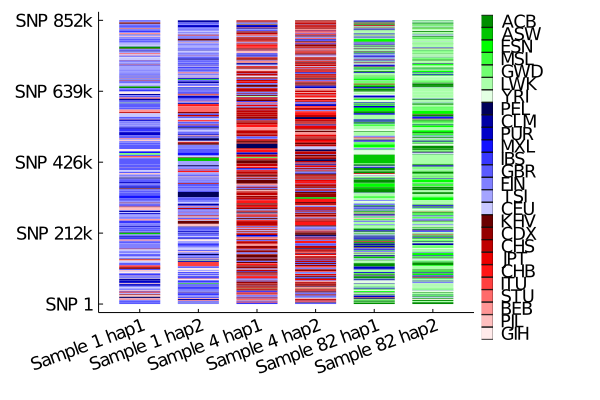

In [15]:
using StatsPlots, FixedPointNumbers

sample1_s1l = length(sample1_s1_pop[1])
sample1_s2l = length(sample1_s2_pop[1])
sample4_s1l = length(sample4_s1_pop[1])
sample4_s2l = length(sample4_s2_pop[1])
sample82_s1l = length(sample82_s1_pop[1])
sample82_s2l = length(sample82_s2_pop[1])
maxlen = max(sample1_s1l, sample1_s2l, sample4_s1l, sample4_s2l, sample82_s1l, sample82_s2l)

# mylabels = reshape(populations, 1, 26)
mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_pop[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_pop[1])
copyto!(@view(mydata[3, 1:sample4_s1l]), sample4_s1_pop[1])
copyto!(@view(mydata[4, 1:sample4_s2l]), sample4_s2_pop[1])
copyto!(@view(mydata[5, 1:sample82_s1l]), sample82_s1_pop[1])
copyto!(@view(mydata[6, 1:sample82_s2l]), sample82_s2_pop[1])

pop_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(pop_colors[1, 1:sample1_s1l]), sample1_s1_colors)
copyto!(@view(pop_colors[2, 1:sample1_s2l]), sample1_s2_colors)
copyto!(@view(pop_colors[3, 1:sample4_s1l]), sample4_s1_colors)
copyto!(@view(pop_colors[4, 1:sample4_s2l]), sample4_s2_colors)
copyto!(@view(pop_colors[5, 1:sample82_s1l]), sample82_s1_colors)
copyto!(@view(pop_colors[6, 1:sample82_s2l]), sample82_s2_colors)

xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 4 hap1", "Sample 4 hap2", 
        "Sample 82 hap1", "Sample 82 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]

# color haplotypes
chrom_plt = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=pop_colors, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20, grid=false,
    right_margin = 30Plots.mm)

# create a plot for legend
color_x = ones(26)
color_y = collect(1:1:26)
scatter!(color_x, color_y, color=goodcolors, ytick=(1:1:26, populations), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=6, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, -0.1, 0.03, 1.1, :bottom, :right)), subplot = 2)

### By continent

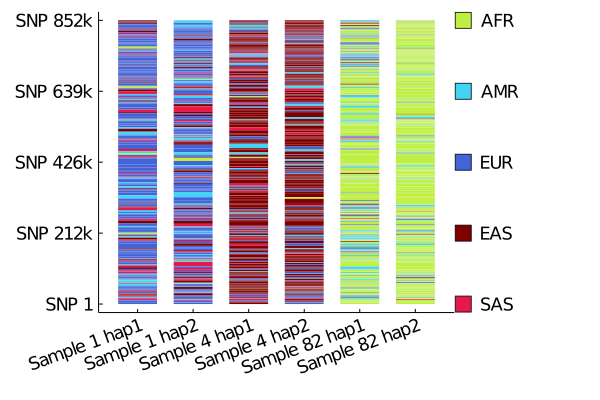

In [51]:
using StatsPlots, FixedPointNumbers

sample1_s1l = length(sample1_s1_cont[1])
sample1_s2l = length(sample1_s2_cont[1])
sample4_s1l = length(sample4_s1_cont[1])
sample4_s2l = length(sample4_s2_cont[1])
sample82_s1l = length(sample82_s1_cont[1])
sample82_s2l = length(sample82_s2_cont[1])
maxlen = max(sample1_s1l, sample1_s2l, sample4_s1l, sample4_s2l, sample82_s1l, sample82_s2l)

# mylabels = reshape(populations, 1, 26)
mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_cont[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_cont[1])
copyto!(@view(mydata[3, 1:sample4_s1l]), sample4_s1_cont[1])
copyto!(@view(mydata[4, 1:sample4_s2l]), sample4_s2_cont[1])
copyto!(@view(mydata[5, 1:sample82_s1l]), sample82_s1_cont[1])
copyto!(@view(mydata[6, 1:sample82_s2l]), sample82_s2_cont[1])

cont_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(cont_colors[1, 1:sample1_s1l]), sample1_s1_cont_colors)
copyto!(@view(cont_colors[2, 1:sample1_s2l]), sample1_s2_cont_colors)
copyto!(@view(cont_colors[3, 1:sample4_s1l]), sample4_s1_cont_colors)
copyto!(@view(cont_colors[4, 1:sample4_s2l]), sample4_s2_cont_colors)
copyto!(@view(cont_colors[5, 1:sample82_s1l]), sample82_s1_cont_colors)
copyto!(@view(cont_colors[6, 1:sample82_s2l]), sample82_s2_cont_colors)

xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 4 hap1", "Sample 4 hap2", 
        "Sample 82 hap1", "Sample 82 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]

# color haplotypes
chrom_plt2 = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=cont_colors, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20, right_margin = 35Plots.mm,
    grid=false)

# create a plot for legend
color_x = ones(5)
color_y = collect(1:1:5)
scatter!(color_x, color_y, color=continent_colors, ytick=(1:1:5, continent), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=8, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, 0.0, 0.05, 1.0, :bottom, :right)), subplot = 2)

# Combined all plots

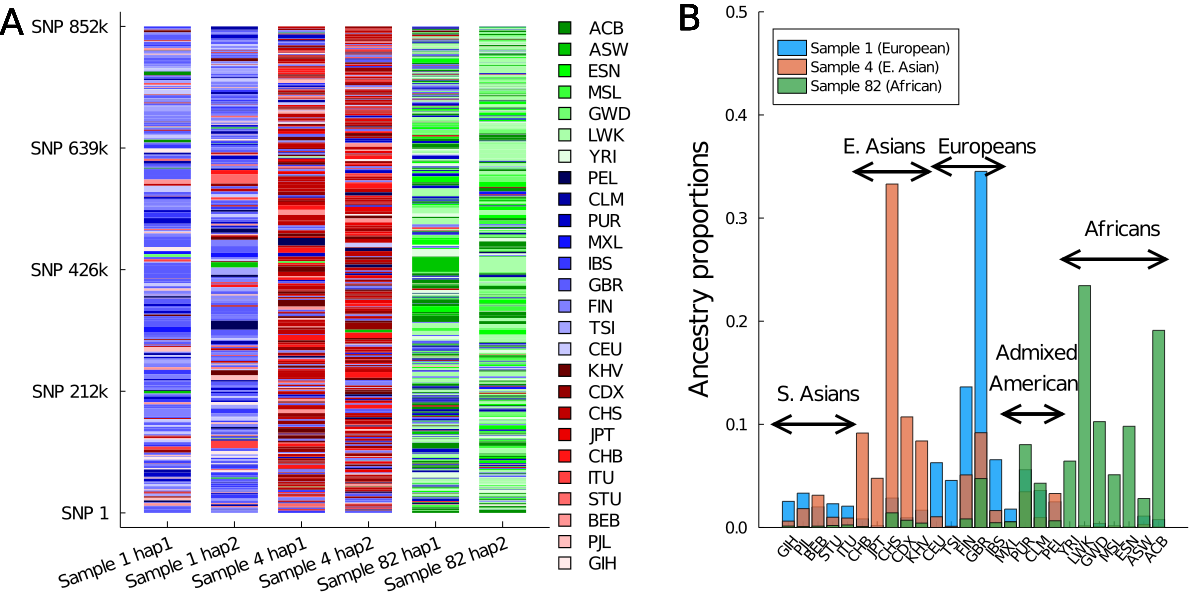

In [45]:
final_plt = plot(chrom_plt, barplot, size=(1200, 600), 
    layout = grid(1, 2, widths=[0.5, 0.5]), left_margin = 5Plots.mm)

fontsize=24
annotate!(final_plt, -1.5, 1.01 , text("A", :left, fontsize), subplot=1)
annotate!(final_plt, 2.8, 26.5 , text("B", :left, fontsize), subplot=2)

In [44]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
savefig(final_plt, "admixture.png") # remember to set dpi=300

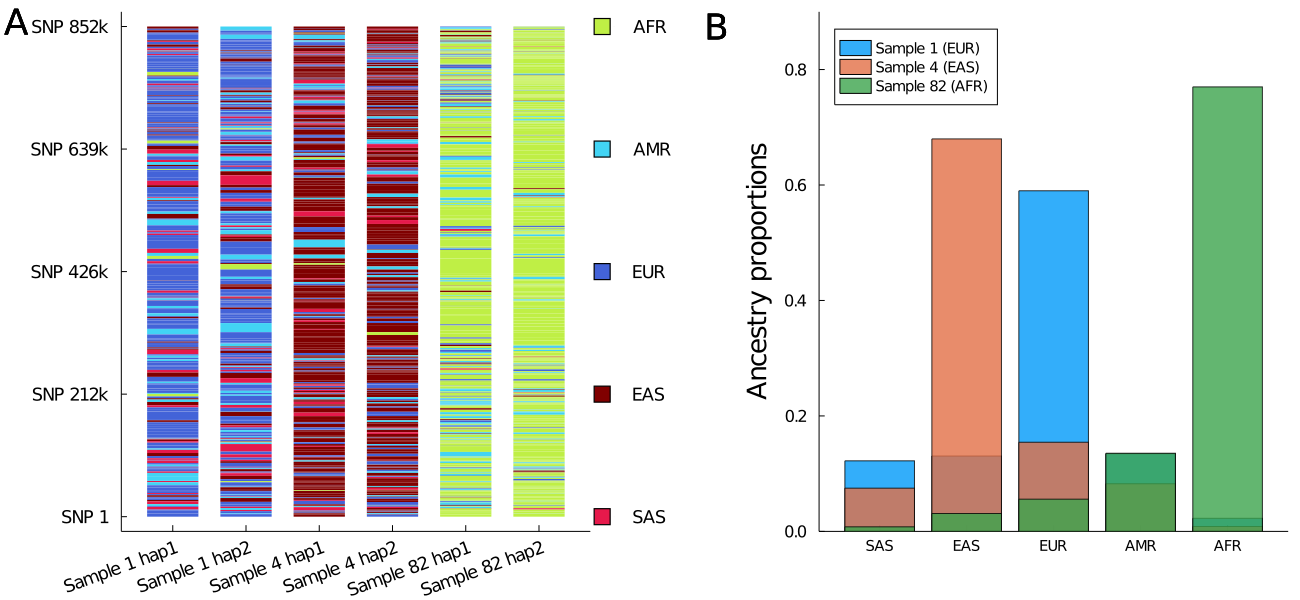

In [49]:
final_plt2 = plot(chrom_plt2, barplot2, size=(1300, 600), 
    layout = grid(1, 2, widths=[0.5, 0.50]), left_margin = 5Plots.mm)

fontsize=24
annotate!(final_plt2, -1.3,  1.01 , text("A", :left, fontsize), subplot=1)
annotate!(final_plt2, 1.9,  5.0 , text("B", :left, fontsize), subplot=2)

In [48]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
savefig(final_plt2, "admixture_superpopulation.png") # remember to set dpi=300

### Combine all 4 plots

Gotta go up and re-generate fresh plots for C and D 

In [56]:
final_plt3 = plot(chrom_plt2, barplot2, size=(1300, 600), 
    layout = grid(1, 2, widths=[0.5, 0.50]), left_margin = 10Plots.mm)
fontsize=24
annotate!(final_plt3, -1.4,  1.01 , text("C", :left, fontsize), subplot=1)
annotate!(final_plt3, 2.2,  5.0 , text("D", :left, fontsize), subplot=2)

final_plt4 = plot(final_plt, final_plt3, 
    size=(1300, 1200), layout = grid(2, 1), left_margin = 10Plots.mm)

In [54]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
savefig(final_plt4, "admixture_all.png") # remember to set dpi=300

In [55]:
;open .